In [1]:
import tensorflow as tf
import keras
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Check TensorFlow version
print("TensorFlow Version: ", tf.__version__)

TensorFlow Version:  2.13.0


In [2]:
# Fetch AAPL data
aapl_data = yf.download('AAPL', start='2020-04-15', end='2024-04-15')

# Display the first few rows of the dataframe
aapl_data.head()

[*********************100%***********************]  1 of 1 completed


C:\Users\Wonyoung\AppData\Roaming\Python\Python310\site-packages\yfinance\utils.py:768: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-04-15,70.599998,71.582497,70.157501,71.107498,69.351120,131154400
2020-04-16,71.845001,72.050003,70.587502,71.672501,69.902161,157125200
2020-04-17,71.172501,71.737503,69.214996,70.699997,68.953697,215250000
2020-04-20,69.487503,70.419998,69.212502,69.232498,67.522423,130015200
2020-04-21,69.070000,69.312500,66.357498,67.092499,65.435295,180991600


In [3]:
# Checking for missing values
aapl_data.isnull().sum()

# Filling missing values, if any
aapl_data.fillna(method='ffill', inplace=True)

C:\Users\Wonyoung\AppData\Local\Temp\ipykernel_24260\1046653174.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  aapl_data.fillna(method='ffill', inplace=True)


In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
aapl_data_scaled = scaler.fit_transform(aapl_data['Close'].values.reshape(-1,1))

In [5]:
X = []
y = []

for i in range(60, len(aapl_data_scaled)):
    X.append(aapl_data_scaled[i-60:i, 0])
    y.append(aapl_data_scaled[i, 0])

In [6]:
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [7]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [8]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, AdditiveAttention, Permute, Reshape, Multiply

model = Sequential()

# Adding LSTM layers with return_sequences=True
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=True))

In [9]:
# Adding self-attention mechanism
# The attention mechanism
attention = AdditiveAttention(name='attention_weight')
# Permute and reshape for compatibility
model.add(Permute((2, 1))) 
model.add(Reshape((-1, X_train.shape[1])))
attention_result = attention([model.output, model.output])
multiply_layer = Multiply()([model.output, attention_result])
# Return to original shape
model.add(Permute((2, 1))) 
model.add(Reshape((-1, 50)))

# Adding a Flatten layer before the final Dense layer
model.add(tf.keras.layers.Flatten())

# Final Dense layer
model.add(Dense(1))

# Compile the model
# model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
# history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2)

In [10]:
from keras.layers import BatchNormalization

# Adding Dropout and Batch Normalization
model.add(Dropout(0.2))
model.add(BatchNormalization())

In [11]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 permute (Permute)           (None, 50, 60)            0         
                                                                 
 reshape (Reshape)           (None, 50, 60)            0         
                                                                 
 permute_1 (Permute)         (None, 60, 50)            0         
                                                                 
 reshape_1 (Reshape)         (None, 60, 50)            0         
                                                                 
 flatten (Flatten)           (None, 3000)              0

In [13]:
# Assuming X_train and y_train are already defined and preprocessed
history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2)

Epoch 1/100
25/25 [==============================] - 5s 58ms/step - loss: 0.5668 - val_loss: 0.4724
Epoch 2/100
25/25 [==============================] - 1s 27ms/step - loss: 0.2971 - val_loss: 0.4388
Epoch 3/100
25/25 [==============================] - 1s 29ms/step - loss: 0.2699 - val_loss: 0.3992
Epoch 4/100
25/25 [==============================] - 1s 28ms/step - loss: 0.2448 - val_loss: 0.3837
Epoch 5/100
25/25 [==============================] - 1s 26ms/step - loss: 0.2221 - val_loss: 0.3421
Epoch 6/100
25/25 [==============================] - 1s 26ms/step - loss: 0.2030 - val_loss: 0.3217
Epoch 7/100
25/25 [==============================] - 1s 26ms/step - loss: 0.1831 - val_loss: 0.3080
Epoch 8/100
25/25 [==============================] - 1s 26ms/step - loss: 0.1658 - val_loss: 0.2782
Epoch 9/100
25/25 [==============================] - 1s 27ms/step - loss: 0.1486 - val_loss: 0.2665
Epoch 10/100
25/25 [==============================] - 1s 27ms/step - loss: 0.1347 - val_loss: 0.2315

In [14]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
25/25 [==============================] - 1s 28ms/step - loss: 0.0062 - val_loss: 0.0099
Epoch 2/100
25/25 [==============================] - 1s 27ms/step - loss: 0.0056 - val_loss: 0.0142
Epoch 3/100
25/25 [==============================] - 1s 27ms/step - loss: 0.0061 - val_loss: 0.0017
Epoch 4/100
25/25 [==============================] - 1s 29ms/step - loss: 0.0064 - val_loss: 0.0040
Epoch 5/100
25/25 [==============================] - 1s 26ms/step - loss: 0.0057 - val_loss: 0.0020
Epoch 6/100
25/25 [==============================] - 1s 26ms/step - loss: 0.0057 - val_loss: 0.0026
Epoch 7/100
25/25 [==============================] - 1s 26ms/step - loss: 0.0067 - val_loss: 0.0025
Epoch 8/100
25/25 [==============================] - 1s 26ms/step - loss: 0.0070 - val_loss: 0.0021
Epoch 9/100
25/25 [==============================] - 1s 26ms/step - loss: 0.0076 - val_loss: 0.0083
Epoch 10/100
25/25 [==============================] - 1s 25ms/step - loss: 0.0068 - val_loss: 0.0014

In [15]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard, CSVLogger

# Callback to save the model periodically
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')

# Callback to reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# Callback for TensorBoard
tensorboard = TensorBoard(log_dir='./logs')

# Callback to log details to a CSV file
csv_logger = CSVLogger('training_log.csv')

# Combining all callbacks
callbacks_list = [early_stopping, model_checkpoint, reduce_lr, tensorboard, csv_logger]

# Fit the model with the callbacks
history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2, callbacks=callbacks_list)

Epoch 1/100
23/25 [==========================>...] - ETA: 0s - loss: 0.0066

d:\Anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 2s 56ms/step - loss: 0.0066 - val_loss: 0.0018 - lr: 0.0010
Epoch 2/100
25/25 [==============================] - 1s 44ms/step - loss: 0.0066 - val_loss: 0.0181 - lr: 0.0010
Epoch 3/100
25/25 [==============================] - 1s 40ms/step - loss: 0.0081 - val_loss: 0.0131 - lr: 0.0010
Epoch 4/100
25/25 [==============================] - 1s 35ms/step - loss: 0.0064 - val_loss: 0.0029 - lr: 0.0010
Epoch 5/100
25/25 [==============================] - 1s 35ms/step - loss: 0.0054 - val_loss: 0.0019 - lr: 0.0010
Epoch 6/100
25/25 [==============================] - 1s 35ms/step - loss: 0.0070 - val_loss: 0.0030 - lr: 0.0010
Epoch 7/100
25/25 [==============================] - 1s 35ms/step - loss: 0.0053 - val_loss: 0.0027 - lr: 1.0000e-04
Epoch 8/100
25/25 [==============================] - 1s 35ms/step - loss: 0.0056 - val_loss: 0.0035 - lr: 1.0000e-04
Epoch 9/100
25/25 [==============================] - 1s 35ms/step - loss: 0.0060 - val_loss: 0.0017 

In [16]:
# Convert X_test and y_test to Numpy arrays if they are not already
X_test = np.array(X_test)
y_test = np.array(y_test)

# Ensure X_test is reshaped similarly to how X_train was reshaped
# This depends on how you preprocessed the training data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Now evaluate the model on the test data
test_loss = model.evaluate(X_test, y_test)
print("Test Loss: ", test_loss)

6/6 [==============================] - 0s 10ms/step - loss: 0.0059
Test Loss:  0.005913846660405397


In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Making predictions
y_pred = model.predict(X_test)

# Calculating MAE and RMSE
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print("Mean Absolute Error: ", mae)
print("Root Mean Square Error: ", rmse)

6/6 [==============================] - 1s 11ms/step
Mean Absolute Error:  0.07230898127576288
Root Mean Square Error:  0.0769015329488837


In [18]:
import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Fetching the latest 60 days of AAPL stock data
data = yf.download('AAPL', period='60d', interval='1d')

# Selecting the 'Close' price and converting to numpy array
closing_prices = data['Close'].values

# Scaling the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(closing_prices.reshape(-1,1))

# Since we need the last 60 days to predict the next day, we reshape the data accordingly
X_latest = np.array([scaled_data[-60:].reshape(60)])

# Reshaping the data for the model (adding batch dimension)
X_latest = np.reshape(X_latest, (X_latest.shape[0], X_latest.shape[1], 1))

# Making predictions for the next 4 candles
predicted_stock_price = model.predict(X_latest)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

print("Predicted Stock Prices for the next 4 days: ", predicted_stock_price)

[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 0s 64ms/step
Predicted Stock Prices for the next 4 days:  [[174.57732]]


C:\Users\Wonyoung\AppData\Roaming\Python\Python310\site-packages\yfinance\utils.py:768: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


In [19]:
import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Fetch the latest 60 days of AAPL stock data
data = yf.download('AAPL', period='60d', interval='1d')

# Select 'Close' price and scale it
closing_prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices)

# Predict the next 4 days iteratively
predicted_prices = []
current_batch = scaled_data[-60:].reshape(1, 60, 1)  # Most recent 60 days

for i in range(4):  # Predicting 4 days
    # Get the prediction (next day)
    next_prediction = model.predict(current_batch)
    
    # Reshape the prediction to fit the batch dimension
    next_prediction_reshaped = next_prediction.reshape(1, 1, 1)
    
    # Append the prediction to the batch used for predicting
    current_batch = np.append(current_batch[:, 1:, :], next_prediction_reshaped, axis=1)
    
    # Inverse transform the prediction to the original price scale
    predicted_prices.append(scaler.inverse_transform(next_prediction)[0, 0])

print("Predicted Stock Prices for the next 4 days: ", predicted_prices)

C:\Users\Wonyoung\AppData\Roaming\Python\Python310\site-packages\yfinance\utils.py:768: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 0s 22ms/step
Predicted Stock Prices for the next 4 days:  [174.57732, 174.44827, 175.2321, 176.36247]


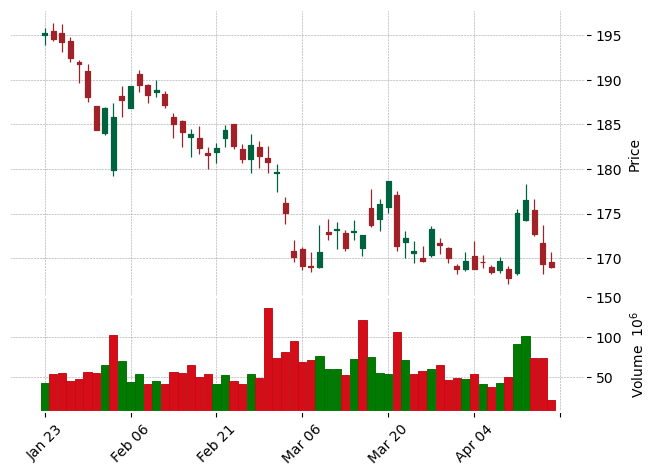

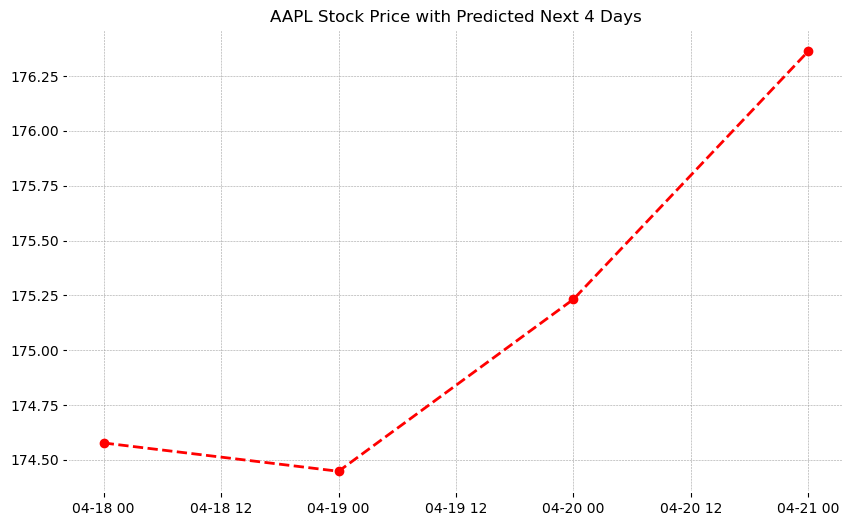

In [20]:
import pandas as pd
import mplfinance as mpf
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame with the fetched AAPL stock data
# Make sure it contains Open, High, Low, Close, and Volume columns

# Creating a list of dates for the predictions
last_date = data.index[-1]
next_day = last_date + pd.Timedelta(days=1)
prediction_dates = pd.date_range(start=next_day, periods=4)

# Assuming 'predicted_prices' is your list of predicted prices for the next 4 days
predictions_df = pd.DataFrame(index=prediction_dates, data=predicted_prices, columns=['Close'])

# Plotting the actual data with mplfinance
mpf.plot(data, type='candle', style='charles', volume=True)

# Overlaying the predicted data
plt.figure(figsize=(10,6))
plt.plot(predictions_df.index, predictions_df['Close'], linestyle='dashed', marker='o', color='red')

plt.title("AAPL Stock Price with Predicted Next 4 Days")
plt.show()

[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 0s 16ms/step


C:\Users\Wonyoung\AppData\Roaming\Python\Python310\site-packages\yfinance\utils.py:768: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


1/1 [==============================] - 0s 31ms/step


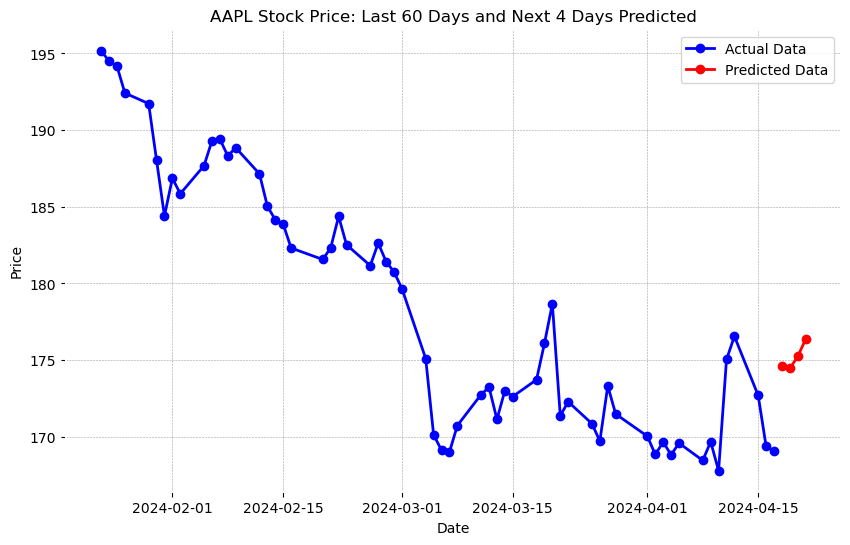

In [21]:
import pandas as pd
import mplfinance as mpf
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt

# Fetch the latest 60 days of AAPL stock data
data = yf.download('AAPL', period='64d', interval='1d') # Fetch 64 days to display last 60 days in the chart

# Select 'Close' price and scale it
closing_prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices)

# Predict the next 4 days iteratively
predicted_prices = []
current_batch = scaled_data[-60:].reshape(1, 60, 1)  # Most recent 60 days

for i in range(4):  # Predicting 4 days
    next_prediction = model.predict(current_batch)
    next_prediction_reshaped = next_prediction.reshape(1, 1, 1)
    current_batch = np.append(current_batch[:, 1:, :], next_prediction_reshaped, axis=1)
    predicted_prices.append(scaler.inverse_transform(next_prediction)[0, 0])

# Creating a list of dates for the predictions
last_date = data.index[-1]
next_day = last_date + pd.Timedelta(days=1)
prediction_dates = pd.date_range(start=next_day, periods=4)

# Adding predictions to the DataFrame
predicted_data = pd.DataFrame(index=prediction_dates, data=predicted_prices, columns=['Close'])

# Combining both actual and predicted data
combined_data = pd.concat([data['Close'], predicted_data['Close']])
combined_data = combined_data[-64:] # Last 60 days of actual data + 4 days of predictions

# Plotting the actual data
plt.figure(figsize=(10,6))
plt.plot(data.index[-60:], data['Close'][-60:], linestyle='-', marker='o', color='blue', label='Actual Data')

# Plotting the predicted data
plt.plot(prediction_dates, predicted_prices, linestyle='-', marker='o', color='red', label='Predicted Data')

plt.title("AAPL Stock Price: Last 60 Days and Next 4 Days Predicted")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()